# Base Components

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
#from fastai.text import *
from fastai.vision import *
from fastai.utils.mem import *
#from fastai.tabular import *
import scipy.signal as s
#import pyts
from itertools import chain 
from fastai.callbacks import *
import sklearn.metrics as smetrics

In [3]:
#Sets the random seed for everything being used with fastai.
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [4]:
path = Path("data/LFP_Prediction")

In [5]:
labels = pd.read_csv(path/"lfp_labels_new_data.csv", index_col = "start")

In [6]:
df = pd.read_csv(path/"model_fr_lfp_new.csv")
df = df.iloc[:len(labels)]

In [7]:
df["avgPNA"] = np.array([df.PNA1, df.PNA2, df.PNA3, df.PNA4, df.PNA5]).mean(0)
df["avgPNC"] = np.array([df.PNC1, df.PNC2, df.PNC3, df.PNC4, df.PNC5]).mean(0)
df["avgITN"] = np.array([df.ITN1, df.ITN2, df.ITN3, df.ITN4, df.ITN5]).mean(0)

In [8]:
#Class to store a single input item in the dataset.
#Stores a time series of every variable passed to it, does not contain the label.
#Shape (1, num_back, num_vars)
class TimeWindow(ItemBase):
    def __init__(self, time_window):
        time_window = np.copy(time_window)
        self.obj = (time_window)
        self.data = torch.Tensor(time_window)
        self.data = self.data[None]
        
    def to_one(self): return self.data
    
    def apply_tfms(self, tfms, **kwargs):
        return
    
    def __repr__(self):
        return "A time points plus"
    
#Contains all of the inputs for the data, as well as the capability to label the inputs.
class TimeWindowList(ItemList):
    _label_cls = CategoryList
    def __init__(self, items, num_back, data_input, **kwargs):
        self.its = items
        super().__init__(items, **kwargs)
        self.num_back = num_back
        self.data_input = data_input
        self.copy_new.append("data_input")
        self.copy_new.append("num_back")
        
    #Returns the input time series starting at index i.
    def get(self, i):
        i = self.items[i]
        return TimeWindow(self.data_input[i - self.num_back : i, :-1])
    
    def reconstruct(self, t:Tensor):
        return TimeWindow(t)
    
    def __len__(self):
        return len(self.items)
    
    #Called to create a LabelList for the data.
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelList':
        "Apply `func` to every input to get its label."
        return self._label_from_list([self.label_func(o) for o in range(0, len(self))], label_cls=label_cls, **kwargs)
    
    #Determines the label of input i based on the next_above list passed to this class.
    def label_func(self, i):
        return int(self.data_input[self.items[i], -1] == 1)

https://www.ijcai.org/Proceedings/2019/0932.pdf

In [9]:
class CNNModel(nn.Module):
    def __init__(self, out_size, num_features):
        super().__init__()
        self.num_features = num_features
        
        #Kernels of size (n, 1) to allow GradCam for individual variables/features.
        self.convs_2d = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = (9, 1), padding = (4, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size = (7, 1), stride = (2, 1), padding = (3, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.Conv2d(128, 1, kernel_size = (1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(1),
            nn.Dropout(0.4),
        )
        
        #Combines all features for GradCam over time.
        self.convs_1d = nn.Sequential(
            nn.Conv1d(num_features, 64, kernel_size = (5), padding = (2)),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),
            nn.Conv1d(64, 128, kernel_size = (5), stride = 2, padding = (2)),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
        )
        
        #Takes CNN features and turns them into the output.
        self.lins = nn.Sequential(
            nn.Linear(1280, 640),
            nn.ReLU(),
            nn.BatchNorm1d(640),
            nn.Dropout(),
            nn.Linear(640, 320),
            nn.ReLU(),
            nn.BatchNorm1d(320),
            nn.Dropout(),
            nn.Linear(320, 160),
            nn.ReLU(),
            nn.BatchNorm1d(160),
            nn.Dropout(),
            nn.Linear(160, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(),
            nn.Linear(32, out_size),
        )
        
    def forward(self, x):
        x = self.convs_2d(x)
        x = torch.squeeze(x, dim = 1)
        x = torch.transpose(x, 1, 2)
        x = self.convs_1d(x)
        x = torch.flatten(x, start_dim = 1)
        x = self.lins(x)
        return x

In [10]:
def isNan(num):
    return num != num

#Returns accuracy where the truth value is 1 (peak is above).
def true_acc(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    mask = targs == 1
    acc = float((input[mask]==targs[mask]).float().mean())
    if isNan(acc):
        return torch.Tensor([0.0]).cuda().mean()
    else:
        return (input[mask]==targs[mask]).float().mean()

#Returns accuracy where the truth value is 0 (peak is bellow).
def false_acc(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    mask = targs == 0
    acc = float((input[mask]==targs[mask]).float().mean())
    if isNan(acc):
        return torch.Tensor([0.0]).cuda().mean()
    else:
        return (input[mask]==targs[mask]).float().mean()

kappa = KappaScore()
auc_roc = AUROC()

In [11]:
#Makes the train and test data sets out of the five folds.
def make_cross_data(splits, test_num, num_back, data_input, seed):
    valid_num = (test_num + 1) % 5
    
    #Concatenates together all of the splits that are not the test set.
    #The validation split is put first.
    inds = splits[valid_num]
    for i in range(5):
        if i != valid_num and i != test_num:
            inds = np.concatenate((inds, splits[i]))
            
    random_seed(seed, True)
    train_data = (TimeWindowList(inds, num_back, data_input)
                .split_by_idx(range(len(splits[0])))
                .label_from_func(lambda x: x)
                .databunch(bs = 64, num_workers = 0))
    
    #Creates the data out of the test split for evaluation.
    random_seed(seed, True)
    test_data = (TimeWindowList(splits[test_num], num_back, data_input)
                .split_none()
                .label_from_func(lambda x: x)
                .databunch(bs = 64, num_workers = 0))
    
    return train_data, test_data

In [12]:
#Performs given metrics on given model with the given data.
#Also performs kappa and auc_roc, as well as returns the confusion matrix.
def get_scores(learn, data, metrics):
    learn.data = data
    learn.loss_func = CrossEntropyFlat()
    interp = ClassificationInterpretation.from_learner(learn, DatasetType.Train)
    preds = np.array(interp.preds)
    kappa = smetrics.cohen_kappa_score(interp.y_true, preds.argmax(1))
    auc = smetrics.roc_auc_score(interp.y_true, preds[:, 1])
    return np.array([interp.confusion_matrix()] + [float(metric(interp.preds, interp.y_true)) for metric in metrics] + [kappa, auc])

In [13]:
#Performs 5 fold cross validation.
#Returns the evaluations for each fold.
def do_cross_valid(num_vars, indexes, data_input, num_back, train_metrics, test_metrics, wd, lr, epochs, base_name = None, num_start = 1, loss_func = None):
    res = []#Stores the evaluation scores for each fold.
    #Makes indexes divisible by 5 so it can be split evenly.
    indexes = np.array(indexes)[:len(indexes)-(len(indexes) % 5)]
    #Gets the five folds.
    splits = np.split(np.array(indexes), 5)
    
    for i in range(5):
        num_label = num_start + i
        train_data, test_data = make_cross_data(splits, i, num_back, data_input, num_label)
        
        #Creates the model.
        random_seed(num_label, True)
        if loss_func != None:
            learn = Learner(train_data, CNNModel(2, num_vars), loss_func = loss_func, metrics = train_metrics, wd = wd)
        else:
            learn = Learner(train_data, CNNModel(2, num_vars), metrics = train_metrics, wd = wd)
        
        #Decides where the model will be saved or if it should be saved.
        random_seed(num_label, True)
        if base_name != None:
            name = base_name + str(num_label)
        else:
            name = "model"
            
        #Used  for early stopping and saving the epoch with the best validation loss.
        callbacks = [EarlyStoppingCallback(learn, patience = 5),
                    SaveModelCallback(learn, every='improvement', monitor='valid_loss', name=name)]
        
        #Fits the model.
        random_seed(num_label, True)
        learn.fit_one_cycle(epochs, lr, callbacks= callbacks)
        
        #Evaluates the model.
        res.append(get_scores(learn, test_data, test_metrics))
        
    return np.array(res)

In [14]:
#Normalizes given confusion matrix.
def normalize_cm(cm):
    cm = cm.astype(float)
    for i in range(len(cm)):
        cm[i] = cm[i] / cm[i].sum()
        
    return cm

In [15]:
#Draws the given confusion matrix.
def draw_cm(cm,title):
    fig,ax = plt.subplots()
    ax.imshow(cm, cmap = "Blues", interpolation = "nearest")
    ax.set_xticks(np.arange(cm.shape[0]))
    ax.set_yticks(np.arange(cm.shape[1]))
    # ... and label them with the respective list entries
    labs=[]
    for i in np.arange(0,cm.shape[0]):
        labs.append('{}'.format(i))
    ax.set_xticklabels(labs)
    ax.set_yticklabels(labs)
    ax.set_ylabel('true')
    ax.set_xlabel('pred')
    ax.set_title(title)
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j, i, np.round(cm[i, j],2),
                       ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

In [16]:
#Displays the results of the cross_validation.
def display_results(results):
    cm = np.array([normalize_cm(result[0]) for result in results]).mean(0)
    draw_cm(cm, "Confusion Matrix")
    print("Accuracy:", results[:, 1].mean())
    print("KappaScore:", results[:, 2].mean())
    print("AUC_ROC:", results[:, 3].mean())

In [45]:
#Metrics calculated each epoch during training.
train_metrics = [accuracy, true_acc, false_acc, kappa]

#Metrics used for evaluation of each fold.
test_metrics = [accuracy]

In [46]:
columns = df.columns
columns

Index(['PNA1', 'PNA2', 'PNA3', 'PNA4', 'PNA5', 'PNC1', 'PNC2', 'PNC3', 'PNC4',
       'PNC5', 'ITN1', 'ITN2', 'ITN3', 'ITN4', 'ITN5', 'rawLFP', 'filtLFP',
       'hilbLFP', 'avgPNA', 'avgPNC', 'avgITN'],
      dtype='object')

# Class Imbalance

In [18]:
#Stores all input except for filtLFP and hilbLFP.
data_input = np.stack([df[columns[i]] for i in range(16)] + [df[columns[i]] for i in range(-3, 0)]  + [labels.next_above], axis = -1)

In [19]:
#Gets the indexes in data_input where it is only 3 or less ms until the next peak.
#Right now only using df[:-30000] so test set is kept, don't know if necessary.
indexes = np.array([i for i in range(100, len(df) - 30000) if labels.time_until_peak[i] <= 3 and labels.time_until_peak[i] >= 1])

In [20]:
num_true = len(np.where(np.array(labels.next_above[indexes]) == 1)[0])
num_true

4512

In [21]:
#Percent of input that is labeled as above threshold.
percent_true = (num_true / len(indexes)) * 100

In [22]:
percent_true

13.447782546494993

In [23]:
len(indexes)

33552

## Unaltered Control

In [76]:
num_vars = 19

In [77]:
random_seed(42, True)
train_data = (TimeWindowList(indexes, num_back, data_input)
            .split_by_idx(range(10000))
            .label_from_func(lambda x: x)
            .databunch(bs = 64, num_workers = 0))

In [78]:
learn = Learner(train_data, CNNModel(2, num_vars), wd = 1e-4)

In [79]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


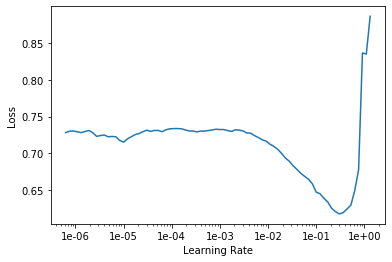

In [80]:
#Helps to choose a learning rate.
#Choose where there is steep decline and then a little back from that.
learn.recorder.plot()

In [164]:
results = do_cross_valid(19, indexes, data_input, num_back, train_metrics, test_metrics, 1e-4, 1e-2, 25)

epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.466925,0.416340,0.857824,0.000000,1.000000,0.000000,00:17
1,0.389623,0.364822,0.857824,0.000000,1.000000,0.000000,00:17
2,0.333495,0.392454,0.860507,0.009760,1.000000,0.031940,00:18
3,0.335064,0.359617,0.860507,0.010290,1.000000,0.031940,00:20
4,0.331693,0.521731,0.762444,0.618728,0.773784,0.317822,00:19
5,0.333291,0.329447,0.860954,0.012187,1.000000,0.037180,00:18
6,0.325972,0.301058,0.878540,0.192147,0.987472,0.291799,00:21
7,0.309916,0.302410,0.873472,0.141443,0.990666,0.229680,00:19
8,0.314447,0.299160,0.872727,0.134187,0.989859,0.226650,00:18
9,0.301806,0.303852,0.869598,0.082821,0.997989,0.147407,00:18


Better model found at epoch 0 with valid_loss value: 0.41633981466293335.
Better model found at epoch 1 with valid_loss value: 0.3648223876953125.
Better model found at epoch 3 with valid_loss value: 0.3596172630786896.
Better model found at epoch 5 with valid_loss value: 0.3294469714164734.
Better model found at epoch 6 with valid_loss value: 0.3010578751564026.
Better model found at epoch 8 with valid_loss value: 0.29915952682495117.
Better model found at epoch 14 with valid_loss value: 0.2984178364276886.
Better model found at epoch 17 with valid_loss value: 0.29802149534225464.
Better model found at epoch 20 with valid_loss value: 0.2940550446510315.


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.472178,0.398370,0.872578,0.000000,1.000000,0.000000,00:18
1,0.396911,0.374539,0.872578,0.000000,1.000000,0.000000,00:17
2,0.329301,0.288902,0.878987,0.050742,0.996237,0.114357,00:17
3,0.335054,0.298139,0.875261,0.023330,0.997558,0.057206,00:17
4,0.319085,0.311877,0.875410,0.022149,0.998196,0.054364,00:18
5,0.320363,0.291075,0.874665,0.014303,0.998974,0.036527,00:17
6,0.320223,0.286660,0.877347,0.036406,0.997893,0.080692,00:18
7,0.306299,0.289561,0.884501,0.127979,0.989732,0.224659,00:17
8,0.313832,0.271381,0.888227,0.222940,0.978356,0.327390,00:17
9,0.306119,0.279956,0.881073,0.070500,0.995831,0.143548,00:18


Better model found at epoch 0 with valid_loss value: 0.3983704447746277.
Better model found at epoch 1 with valid_loss value: 0.37453922629356384.
Better model found at epoch 2 with valid_loss value: 0.28890153765678406.
Better model found at epoch 6 with valid_loss value: 0.28665968775749207.
Better model found at epoch 8 with valid_loss value: 0.2713812291622162.
Epoch 14: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.446495,0.385662,0.860954,0.000000,1.000000,0.000000,00:17
1,0.372611,0.324661,0.869300,0.056371,0.998422,0.110927,00:17
2,0.332676,0.302033,0.880179,0.191191,0.985734,0.294853,00:17
3,0.321172,0.353416,0.863934,0.017130,1.000000,0.036349,00:17
4,0.316625,0.306274,0.877347,0.102488,0.998486,0.196258,00:18
5,0.321275,0.307081,0.877347,0.102449,0.999078,0.192844,00:17
6,0.328359,0.306814,0.876602,0.101752,0.998346,0.189661,00:18
7,0.311442,0.327516,0.864083,0.013576,1.000000,0.038137,00:17
8,0.309315,0.295223,0.876304,0.100203,0.997992,0.188850,00:18
9,0.314092,0.322267,0.885246,0.276833,0.976528,0.378213,00:18


Better model found at epoch 0 with valid_loss value: 0.3856618106365204.
Better model found at epoch 1 with valid_loss value: 0.32466062903404236.
Better model found at epoch 2 with valid_loss value: 0.3020326793193817.
Better model found at epoch 8 with valid_loss value: 0.29522284865379333.
Better model found at epoch 12 with valid_loss value: 0.29227885603904724.
Epoch 18: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.505481,0.416609,0.861848,0.000000,1.000000,0.000000,00:17
1,0.386787,0.374364,0.861848,0.000000,1.000000,0.000000,00:17
2,0.347382,0.311470,0.869300,0.050485,0.998093,0.102959,00:17
3,0.331164,0.324824,0.863040,0.008623,0.999431,0.019348,00:18
4,0.320656,0.329938,0.864978,0.018501,0.999383,0.042829,00:17
5,0.323955,0.306042,0.863189,0.007130,1.000000,0.016618,00:17
6,0.311175,0.284847,0.883905,0.182180,0.990131,0.299628,00:17
7,0.314158,0.291225,0.874069,0.086553,0.995770,0.170092,00:17
8,0.311090,0.297707,0.872876,0.072134,0.997969,0.143982,00:17
9,0.308257,0.292288,0.890462,0.309662,0.972228,0.429723,00:18


Better model found at epoch 0 with valid_loss value: 0.416608989238739.
Better model found at epoch 1 with valid_loss value: 0.374363511800766.
Better model found at epoch 2 with valid_loss value: 0.31146958470344543.
Better model found at epoch 5 with valid_loss value: 0.3060416281223297.
Better model found at epoch 6 with valid_loss value: 0.2848474383354187.
Better model found at epoch 10 with valid_loss value: 0.2802067697048187.
Better model found at epoch 11 with valid_loss value: 0.2800508141517639.
Better model found at epoch 16 with valid_loss value: 0.27975594997406006.
Better model found at epoch 19 with valid_loss value: 0.27897289395332336.
Better model found at epoch 21 with valid_loss value: 0.2785484790802002.
Better model found at epoch 23 with valid_loss value: 0.27830126881599426.


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.467097,0.398577,0.874367,0.000000,1.000000,0.000000,00:17
1,0.421078,0.379531,0.874367,0.000000,1.000000,0.000000,00:17
2,0.349655,0.293620,0.888674,0.157135,0.989256,0.258724,00:17
3,0.319143,0.286807,0.885693,0.119958,0.993182,0.199628,00:17
4,0.327675,0.286534,0.885544,0.131016,0.989055,0.224634,00:17
5,0.309443,0.300490,0.887928,0.220565,0.976683,0.322704,00:17
6,0.315354,0.281194,0.891356,0.216001,0.981393,0.328476,00:17
7,0.312667,0.306987,0.876453,0.014042,0.999778,0.030386,00:17
8,0.311865,0.286958,0.882414,0.069697,0.997116,0.130474,00:17
9,0.320532,0.286629,0.885544,0.091073,0.997076,0.168034,00:17


Better model found at epoch 0 with valid_loss value: 0.39857685565948486.
Better model found at epoch 1 with valid_loss value: 0.37953129410743713.
Better model found at epoch 2 with valid_loss value: 0.293620228767395.
Better model found at epoch 3 with valid_loss value: 0.28680720925331116.
Better model found at epoch 4 with valid_loss value: 0.28653445839881897.
Better model found at epoch 6 with valid_loss value: 0.2811938226222992.
Better model found at epoch 10 with valid_loss value: 0.27214521169662476.
Better model found at epoch 15 with valid_loss value: 0.27210307121276855.
Epoch 21: early stopping


In [165]:
results

array([[array([[5740,   77],
       [ 630,  209]], dtype=int64), 0.8937800526618958, 0.32852023061341085,
        0.8646546444466437],
       [array([[5605,  102],
       [ 690,  259]], dtype=int64), 0.8810096383094788, 0.343859524217898,
        0.8561207161892213],
       [array([[5766,   46],
       [ 737,  107]], dtype=int64), 0.8823617696762085, 0.18284139529691268,
        0.861166878137405],
       [array([[5713,   21],
       [ 739,  183]], dtype=int64), 0.885817289352417, 0.28937638372236774,
        0.8647510719255013],
       [array([[5663,   73],
       [ 697,  223]], dtype=int64), 0.8843148946762085, 0.32109127286908457,
        0.8777336880722819]], dtype=object)

Accuracy: 0.8854567289352417
KappaScore: 0.29313776134393477
AUC_ROC: 0.8648853997542105


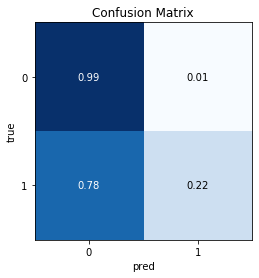

In [166]:
display_results(results)

## Removing Falses

In [250]:
#Percent of falses that should remain to make the data 50/50
evener = percent_true / (100 - percent_true)

In [251]:
#Gets the indexes in data_input where it is only 3 or less ms until the next peak.
#Right now only using df[:-30000] so test set is kept, don't know if necessary.
#Evens the labels to about 50/50.
random_seed(42, True)
indexes = np.array([i for i in range(100, len(df) - 30000) if (labels.time_until_peak[i] <= 3 and labels.time_until_peak[i] >= 1)
                   and (labels.next_above[i] == 1 or np.random.choice([0, 1], p =[1-evener, evener]) == 1)])

In [252]:
#Percent of the new indexes that are labeled true.
(len(np.where(np.array(labels.next_above[indexes]) == 1)[0]) / len(indexes)) * 100

50.233800935203746

In [253]:
num_vars = 19

In [254]:
random_seed(42, True)
train_data = (TimeWindowList(indexes, num_back, data_input)
            .split_by_idx(range(2000))
            .label_from_func(lambda x: x)
            .databunch(bs = 64, num_workers = 0))

In [255]:
random_seed(42, True)
learn = Learner(train_data, CNNModel(2, num_vars), wd = 1e-4)

In [256]:
random_seed(42, True)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


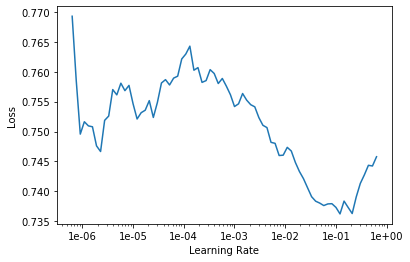

In [259]:
#Helps to choose a learning rate.
#Choose where there is steep decline and then a little back from that.
learn.recorder.plot(skip_end = 10)

In [260]:
results = do_cross_valid(19, indexes, data_input, num_back, train_metrics, test_metrics, 1e-4, 5e-3, 25)

epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.728675,0.697322,0.483296,0.000000,1.000000,0.000000,00:04
1,0.709525,0.699695,0.483296,0.000000,1.000000,0.000000,00:04
2,0.700277,0.696978,0.483296,0.000000,1.000000,0.000000,00:04
3,0.696428,0.688092,0.562361,0.286627,0.860550,0.141019,00:04
4,0.665053,0.558304,0.724944,0.731031,0.727117,0.449807,00:04
5,0.614802,0.559396,0.731069,0.633298,0.847039,0.466051,00:04
6,0.584867,0.498928,0.760022,0.885000,0.628509,0.515921,00:04
7,0.553709,0.550083,0.734410,0.598754,0.886048,0.473850,00:04
8,0.555597,0.498413,0.771158,0.800834,0.743840,0.541378,00:04
9,0.539626,0.541499,0.723274,0.579680,0.881778,0.452072,00:04


Better model found at epoch 0 with valid_loss value: 0.6973223686218262.
Better model found at epoch 2 with valid_loss value: 0.696977972984314.
Better model found at epoch 3 with valid_loss value: 0.6880917549133301.
Better model found at epoch 4 with valid_loss value: 0.558304488658905.
Better model found at epoch 6 with valid_loss value: 0.4989278316497803.
Better model found at epoch 8 with valid_loss value: 0.4984133541584015.
Better model found at epoch 10 with valid_loss value: 0.4932161569595337.
Better model found at epoch 12 with valid_loss value: 0.48328009247779846.
Better model found at epoch 15 with valid_loss value: 0.47518664598464966.
Better model found at epoch 17 with valid_loss value: 0.4684624671936035.
Epoch 23: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.720080,0.692682,0.515590,0.028968,0.970981,-0.004655,00:04
1,0.709251,0.687356,0.531737,0.042981,0.982188,0.029046,00:04
2,0.692320,0.668012,0.603563,0.261535,0.910146,0.186900,00:04
3,0.656061,0.567963,0.722160,0.759654,0.680258,0.445466,00:04
4,0.593222,0.544642,0.726058,0.842457,0.605223,0.456515,00:04
5,0.569223,0.523500,0.737751,0.906591,0.573389,0.481470,00:04
6,0.554224,0.518787,0.720490,0.552617,0.859533,0.434157,00:04
7,0.547047,0.511900,0.744432,0.786483,0.688419,0.490347,00:04
8,0.536115,0.489715,0.764477,0.796364,0.720350,0.529885,00:04
9,0.527076,0.499743,0.753341,0.821797,0.676639,0.509021,00:04


Better model found at epoch 0 with valid_loss value: 0.6926822066307068.
Better model found at epoch 1 with valid_loss value: 0.6873564124107361.
Better model found at epoch 2 with valid_loss value: 0.6680117845535278.
Better model found at epoch 3 with valid_loss value: 0.5679634809494019.
Better model found at epoch 4 with valid_loss value: 0.5446418523788452.
Better model found at epoch 5 with valid_loss value: 0.5235000252723694.
Better model found at epoch 6 with valid_loss value: 0.518787145614624.
Better model found at epoch 7 with valid_loss value: 0.5118995904922485.
Better model found at epoch 8 with valid_loss value: 0.489714652299881.
Better model found at epoch 10 with valid_loss value: 0.48316624760627747.
Better model found at epoch 14 with valid_loss value: 0.48028475046157837.
Epoch 20: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.735406,0.698116,0.502227,0.000000,0.997773,0.000000,00:04
1,0.720089,0.695948,0.502227,0.000000,0.997773,0.000000,00:04
2,0.701946,0.695935,0.506125,0.007713,0.996725,0.007874,00:04
3,0.679054,0.645967,0.633630,0.388918,0.868499,0.265694,00:04
4,0.649257,0.616015,0.679844,0.493485,0.854020,0.358673,00:04
5,0.617809,0.647956,0.629733,0.279782,0.970782,0.257170,00:05
6,0.590121,0.512078,0.735523,0.836034,0.626801,0.471500,00:04
7,0.560137,0.512257,0.734410,0.595094,0.874895,0.468115,00:04
8,0.557536,0.535082,0.699332,0.947588,0.452088,0.399979,00:04
9,0.545361,0.544696,0.738307,0.625514,0.841809,0.476074,00:04


Better model found at epoch 0 with valid_loss value: 0.6981159448623657.
Better model found at epoch 1 with valid_loss value: 0.6959476470947266.
Better model found at epoch 2 with valid_loss value: 0.6959345936775208.
Better model found at epoch 3 with valid_loss value: 0.6459670066833496.
Better model found at epoch 4 with valid_loss value: 0.6160147190093994.
Better model found at epoch 6 with valid_loss value: 0.5120779275894165.
Epoch 12: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.722473,0.704474,0.469933,0.000000,0.997773,0.000000,00:04
1,0.707455,0.700307,0.486080,0.042131,0.985751,0.027452,00:04
2,0.682464,0.621195,0.663697,0.504072,0.834187,0.339860,00:04
3,0.627182,0.523714,0.746659,0.813134,0.657396,0.487588,00:04
4,0.581563,0.500839,0.755568,0.873443,0.609335,0.502236,00:04
5,0.564453,0.521972,0.735523,0.663338,0.813798,0.475019,00:04
6,0.543103,0.485130,0.776726,0.842390,0.691243,0.548218,00:04
7,0.541961,0.493430,0.762806,0.823181,0.685408,0.520604,00:04
8,0.524988,0.489698,0.767817,0.849745,0.664253,0.529235,00:04
9,0.532374,0.483701,0.767817,0.875042,0.637129,0.527825,00:04


Better model found at epoch 0 with valid_loss value: 0.7044735550880432.
Better model found at epoch 1 with valid_loss value: 0.7003074884414673.
Better model found at epoch 2 with valid_loss value: 0.6211949586868286.
Better model found at epoch 3 with valid_loss value: 0.5237137079238892.
Better model found at epoch 4 with valid_loss value: 0.5008391737937927.
Better model found at epoch 6 with valid_loss value: 0.48513033986091614.
Better model found at epoch 9 with valid_loss value: 0.4837011992931366.
Better model found at epoch 12 with valid_loss value: 0.47969499230384827.
Better model found at epoch 13 with valid_loss value: 0.4772533178329468.
Better model found at epoch 16 with valid_loss value: 0.47602415084838867.
Better model found at epoch 17 with valid_loss value: 0.47442513704299927.
Better model found at epoch 22 with valid_loss value: 0.47096356749534607.


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.729769,0.699235,0.485523,1.000000,0.000000,0.000000,00:04
1,0.716285,0.691964,0.517261,0.064960,0.941536,0.009319,00:04
2,0.701921,0.682517,0.571270,0.271025,0.855866,0.127517,00:04
3,0.679720,0.613626,0.685412,0.608474,0.752173,0.368155,00:04
4,0.618315,0.535467,0.729399,0.755857,0.691230,0.459668,00:04
5,0.572106,0.510807,0.749443,0.728651,0.761927,0.498207,00:04
6,0.551436,0.526832,0.738864,0.856877,0.622565,0.481025,00:04
7,0.543788,0.512195,0.741648,0.813394,0.670700,0.485222,00:04
8,0.536509,0.526793,0.741091,0.828985,0.654432,0.484625,00:04
9,0.522066,0.498618,0.755568,0.783932,0.722021,0.511781,00:04


Better model found at epoch 0 with valid_loss value: 0.699234664440155.
Better model found at epoch 1 with valid_loss value: 0.6919638514518738.
Better model found at epoch 2 with valid_loss value: 0.6825174689292908.
Better model found at epoch 3 with valid_loss value: 0.6136260032653809.
Better model found at epoch 4 with valid_loss value: 0.5354672074317932.
Better model found at epoch 5 with valid_loss value: 0.5108071565628052.
Better model found at epoch 9 with valid_loss value: 0.4986182451248169.
Better model found at epoch 12 with valid_loss value: 0.49464908242225647.
Better model found at epoch 13 with valid_loss value: 0.4932381212711334.
Better model found at epoch 15 with valid_loss value: 0.48759686946868896.
Better model found at epoch 16 with valid_loss value: 0.485494464635849.
Better model found at epoch 17 with valid_loss value: 0.477782279253006.
Epoch 23: early stopping


In [261]:
results

array([[array([[713, 207],
       [215, 657]], dtype=int64), 0.7645089030265808, 0.5285668688158315,
        0.8505970781810929],
       [array([[691, 173],
       [233, 695]], dtype=int64), 0.7734375, 0.5473801560758083, 0.8569417005906769],
       [array([[587, 343],
       [156, 706]], dtype=int64), 0.7215401530265808, 0.44666579209869095,
        0.8174475463413418],
       [array([[695, 207],
       [211, 679]], dtype=int64), 0.7667410969734192, 0.5334472741405857,
        0.8551782555619223],
       [array([[614, 227],
       [163, 788]], dtype=int64), 0.7823660969734192, 0.5611544310919272,
        0.8525952405065823]], dtype=object)

Accuracy: 0.76171875
KappaScore: 0.5234429044445686
AUC_ROC: 0.8465519642363233


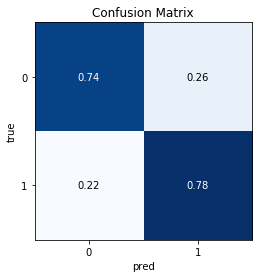

In [262]:
display_results(results)

## Removing Falses Extreme

In [138]:
#Percent of falses that should remain to make the data 50/50
evener = 0.10

In [139]:
#Gets the indexes in data_input where it is only 3 or less ms until the next peak.
#Right now only using df[:-30000] so test set is kept, don't know if necessary.
#Evens the labels to about 50/50.
random_seed(42, True)
indexes = np.array([i for i in range(100, len(df) - 30000) if (labels.time_until_peak[i] <= 3 and labels.time_until_peak[i] >= 1)
                   and (labels.next_above[i] == 1 or np.random.choice([0, 1], p =[1-evener, evener]) == 1)])

In [140]:
#Percent of the new indexes that are labeled true.
(len(np.where(np.array(labels.next_above[indexes]) == 1)[0]) / len(indexes)) * 100

61.030704720681726

In [141]:
num_vars = 19

In [142]:
random_seed(42, True)
train_data = (TimeWindowList(indexes, num_back, data_input)
            .split_by_idx(range(2000))
            .label_from_func(lambda x: x)
            .databunch(bs = 64, num_workers = 0))

In [143]:
random_seed(42, True)
learn = Learner(train_data, CNNModel(2, num_vars), wd = 1e-4)

In [144]:
random_seed(42, True)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


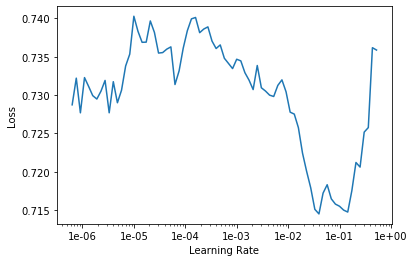

In [145]:
#Helps to choose a learning rate.
#Choose where there is steep decline and then a little back from that.
learn.recorder.plot(skip_end = 10)

In [146]:
results = do_cross_valid(19, indexes, data_input, num_back, train_metrics, test_metrics, 1e-4, 1e-2, 25)

epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.715317,0.696844,0.410014,0.079638,0.961492,0.033715,00:04
1,0.684692,0.650221,0.627876,1.000000,0.000000,0.000000,00:04
2,0.658685,0.602352,0.733424,0.845237,0.542097,0.405769,00:04
3,0.622222,0.490208,0.759811,0.901699,0.509414,0.451254,00:04
4,0.585166,0.467174,0.780785,0.860166,0.645317,0.520226,00:04
5,0.565387,0.499884,0.772666,0.895176,0.576072,0.487312,00:04
6,0.551075,0.464589,0.792963,0.882441,0.649967,0.542724,00:04
7,0.536016,0.546674,0.735453,0.958921,0.359474,0.360196,00:04
8,0.528913,0.550481,0.711773,0.627842,0.864561,0.440770,00:04
9,0.521771,0.501382,0.763870,0.761521,0.779157,0.513253,00:04


Better model found at epoch 0 with valid_loss value: 0.6968435645103455.
Better model found at epoch 1 with valid_loss value: 0.6502211093902588.
Better model found at epoch 2 with valid_loss value: 0.6023522019386292.
Better model found at epoch 3 with valid_loss value: 0.49020835757255554.
Better model found at epoch 4 with valid_loss value: 0.46717408299446106.
Better model found at epoch 6 with valid_loss value: 0.4645892083644867.
Better model found at epoch 10 with valid_loss value: 0.46446681022644043.
Better model found at epoch 16 with valid_loss value: 0.4610093832015991.
Better model found at epoch 17 with valid_loss value: 0.4496696889400482.
Epoch 23: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.693788,0.690048,0.552774,0.569216,0.521684,0.094640,00:04
1,0.670008,0.665319,0.637348,0.802386,0.395934,0.208553,00:04
2,0.641147,0.601449,0.669824,0.885508,0.356366,0.257838,00:04
3,0.602738,0.551056,0.721245,0.942370,0.396793,0.369424,00:04
4,0.562487,0.655849,0.697564,0.962052,0.311915,0.301889,00:04
5,0.550106,0.509665,0.748309,0.764787,0.717837,0.482829,00:04
6,0.534954,0.526558,0.738160,0.745619,0.720453,0.464373,00:04
7,0.537594,0.569980,0.700271,0.977418,0.294511,0.303603,00:04
8,0.523838,0.564964,0.702300,0.983442,0.291620,0.306874,00:04
9,0.529265,0.498357,0.754398,0.921128,0.512109,0.458090,00:03


Better model found at epoch 0 with valid_loss value: 0.6900482177734375.
Better model found at epoch 1 with valid_loss value: 0.6653192639350891.
Better model found at epoch 2 with valid_loss value: 0.6014489531517029.
Better model found at epoch 3 with valid_loss value: 0.5510562658309937.
Better model found at epoch 5 with valid_loss value: 0.5096647143363953.
Better model found at epoch 9 with valid_loss value: 0.49835726618766785.
Better model found at epoch 10 with valid_loss value: 0.48471060395240784.
Better model found at epoch 12 with valid_loss value: 0.4822708070278168.
Better model found at epoch 16 with valid_loss value: 0.47867774963378906.
Better model found at epoch 18 with valid_loss value: 0.47261345386505127.
Epoch 24: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.724884,0.700602,0.402571,0.044864,0.955955,0.000358,00:04
1,0.695047,0.675589,0.606901,1.000000,0.000000,0.000000,00:04
2,0.669477,0.655163,0.606901,1.000000,0.000000,0.000000,00:04
3,0.631075,0.546780,0.714479,0.886151,0.449223,0.361330,00:03
4,0.585461,0.538996,0.730717,0.936488,0.411257,0.383285,00:04
5,0.560372,0.562308,0.701624,0.970665,0.284445,0.291541,00:04
6,0.545811,0.495732,0.746955,0.905690,0.498992,0.435437,00:04
7,0.538301,0.882724,0.483085,0.156668,0.998117,0.119954,00:04
8,0.537384,0.512478,0.730717,0.968081,0.364215,0.371202,00:03
9,0.526804,0.492826,0.780785,0.880391,0.620027,0.525908,00:04


Better model found at epoch 0 with valid_loss value: 0.7006017565727234.
Better model found at epoch 1 with valid_loss value: 0.6755892038345337.
Better model found at epoch 2 with valid_loss value: 0.6551626920700073.
Better model found at epoch 3 with valid_loss value: 0.5467802286148071.
Better model found at epoch 4 with valid_loss value: 0.5389960408210754.
Better model found at epoch 6 with valid_loss value: 0.49573224782943726.
Better model found at epoch 9 with valid_loss value: 0.4928256869316101.
Better model found at epoch 10 with valid_loss value: 0.4710708260536194.
Epoch 16: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.695554,0.696396,0.441813,0.193458,0.864148,0.043912,00:03
1,0.686551,0.667265,0.627199,1.000000,0.000000,0.000000,00:04
2,0.677096,0.653577,0.627199,1.000000,0.000000,0.000000,00:04
3,0.643448,0.503518,0.765223,0.873884,0.565303,0.474554,00:04
4,0.593878,0.493868,0.766576,0.911761,0.500528,0.463105,00:04
5,0.552841,0.495298,0.773342,0.808252,0.692821,0.516207,00:04
6,0.541730,0.508134,0.746955,0.701401,0.807840,0.490755,00:04
7,0.536248,0.505197,0.753045,0.959366,0.393368,0.407589,00:04
8,0.532901,0.500465,0.762517,0.776157,0.722827,0.502603,00:04
9,0.525627,0.462939,0.788904,0.921437,0.548729,0.517326,00:04


Better model found at epoch 0 with valid_loss value: 0.6963964104652405.
Better model found at epoch 1 with valid_loss value: 0.6672650575637817.
Better model found at epoch 2 with valid_loss value: 0.653576672077179.
Better model found at epoch 3 with valid_loss value: 0.5035176873207092.
Better model found at epoch 4 with valid_loss value: 0.4938676059246063.
Better model found at epoch 9 with valid_loss value: 0.462938517332077.
Better model found at epoch 14 with valid_loss value: 0.44891273975372314.
Epoch 20: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.723034,0.675609,0.594046,1.000000,0.000000,0.000000,00:04
1,0.693126,0.671944,0.594046,1.000000,0.000000,0.000000,00:04
2,0.680216,0.672311,0.594046,1.000000,0.000000,0.000000,00:04
3,0.665747,0.629101,0.631258,0.927687,0.193153,0.138906,00:03
4,0.625614,0.554330,0.730717,0.915914,0.441267,0.400898,00:04
5,0.567946,0.553044,0.721922,0.703416,0.735125,0.438123,00:04
6,0.548442,0.565322,0.723951,0.910282,0.444271,0.385845,00:04
7,0.528528,0.550329,0.702300,0.972606,0.307961,0.311557,00:03
8,0.527115,0.516639,0.730717,0.935327,0.429619,0.395420,00:04
9,0.525570,0.513961,0.753045,0.776437,0.716926,0.491330,00:04


Better model found at epoch 0 with valid_loss value: 0.6756089329719543.
Better model found at epoch 1 with valid_loss value: 0.6719444394111633.
Better model found at epoch 3 with valid_loss value: 0.6291009783744812.
Better model found at epoch 4 with valid_loss value: 0.5543303489685059.
Better model found at epoch 5 with valid_loss value: 0.5530440211296082.
Better model found at epoch 7 with valid_loss value: 0.55032879114151.
Better model found at epoch 8 with valid_loss value: 0.5166394114494324.
Better model found at epoch 9 with valid_loss value: 0.5139613747596741.
Better model found at epoch 10 with valid_loss value: 0.5127213001251221.
Better model found at epoch 11 with valid_loss value: 0.486569881439209.
Better model found at epoch 15 with valid_loss value: 0.4839361011981964.
Better model found at epoch 17 with valid_loss value: 0.4816799461841583.
Better model found at epoch 19 with valid_loss value: 0.47977274656295776.
Better model found at epoch 20 with valid_loss v

In [147]:
results

array([[array([[352, 246],
       [ 86, 788]], dtype=int64), 0.7744565010070801, 0.5118544385223305,
        0.8533517522175367],
       [array([[412, 137],
       [164, 759]], dtype=int64), 0.795516312122345, 0.567123116363409, 0.85593228701056],
       [array([[396, 202],
       [138, 736]], dtype=int64), 0.76902174949646, 0.5129811996418979, 0.8439535293082203],
       [array([[410, 168],
       [161, 733]], dtype=int64), 0.776494562625885, 0.5303883047014697,
        0.8551957300883244],
       [array([[389, 158],
       [131, 794]], dtype=int64), 0.8036684989929199, 0.5753326199108755,
        0.8513226938089827]], dtype=object)

Accuracy: 0.783831524848938
KappaScore: 0.5395359358279965
AUC_ROC: 0.8519511984867247


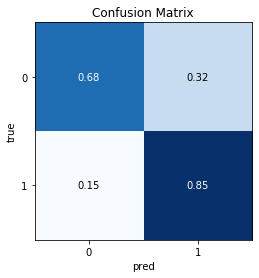

In [148]:
display_results(results)

## Loss Weighting 

In [99]:
weights = [percent_true / 100, 1-percent_true/100]
weights

[0.13447782546494993, 0.8655221745350501]

In [100]:
num_vars = 19
num_back = 40

In [115]:
random_seed(42, True)
train_data = (TimeWindowList(indexes, num_back, data_input)
            .split_by_idx(range(10000))
            .label_from_func(lambda x: x)
            .databunch(bs = 64, num_workers = 0))

In [116]:
learn = Learner(train_data, CNNModel(2, num_vars), 
                loss_func = torch.nn.modules.loss.CrossEntropyLoss(weight = torch.Tensor(weights).cuda()), wd = 1e-4)

In [117]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


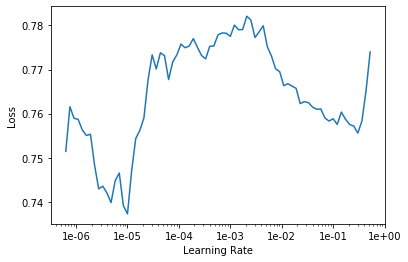

In [118]:
#Helps to choose a learning rate.
#Choose where there is steep decline and then a little back from that.
learn.recorder.plot(skip_end = 10)

In [120]:
results = do_cross_valid(19, indexes, data_input, num_back, train_metrics, test_metrics, 1e-4, 7e-3, 25)

epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.525489,0.458157,0.857824,0.000000,1.000000,0.000000,00:18
1,0.403289,0.398062,0.857824,0.000000,1.000000,0.000000,00:17
2,0.343984,0.384801,0.859762,0.006568,1.000000,0.023153,00:17
3,0.327430,0.314472,0.867958,0.071266,0.996505,0.138490,00:17
4,0.322658,0.351978,0.865276,0.359590,0.937434,0.392422,00:18
5,0.318146,0.426735,0.859314,0.370782,0.926628,0.390176,00:17
6,0.316126,0.298132,0.879285,0.258557,0.975524,0.352144,00:17
7,0.307284,0.302313,0.874218,0.151479,0.989468,0.243549,00:18
8,0.304033,0.318506,0.867511,0.070731,0.997102,0.131342,00:17
9,0.298965,0.306513,0.869151,0.089621,0.997135,0.148639,00:17


Better model found at epoch 0 with valid_loss value: 0.45815661549568176.
Better model found at epoch 1 with valid_loss value: 0.39806169271469116.
Better model found at epoch 2 with valid_loss value: 0.38480108976364136.
Better model found at epoch 3 with valid_loss value: 0.3144717812538147.
Better model found at epoch 6 with valid_loss value: 0.29813238978385925.
Epoch 12: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.538783,0.440426,0.872578,0.000000,1.000000,0.000000,00:17
1,0.380818,0.335126,0.872578,0.000000,1.000000,0.000000,00:17
2,0.329502,0.301111,0.876304,0.034743,0.996332,0.079766,00:17
3,0.329465,0.297977,0.876751,0.027512,0.997530,0.076224,00:17
4,0.316934,0.301795,0.874218,0.007736,1.000000,0.022239,00:17
5,0.320366,0.295837,0.874665,0.015722,0.998553,0.039806,00:17
6,0.316650,0.280596,0.883607,0.102393,0.992157,0.198337,00:17
7,0.303833,0.278888,0.878540,0.051610,0.996235,0.108912,00:17
8,0.311572,0.289788,0.886289,0.300460,0.963647,0.380707,00:17
9,0.302628,0.286087,0.880924,0.069449,0.995516,0.144527,00:17


Better model found at epoch 0 with valid_loss value: 0.4404264986515045.
Better model found at epoch 1 with valid_loss value: 0.33512556552886963.
Better model found at epoch 2 with valid_loss value: 0.3011114299297333.
Better model found at epoch 3 with valid_loss value: 0.2979770600795746.
Better model found at epoch 5 with valid_loss value: 0.2958371639251709.
Better model found at epoch 6 with valid_loss value: 0.28059592843055725.
Better model found at epoch 7 with valid_loss value: 0.27888843417167664.
Better model found at epoch 10 with valid_loss value: 0.2754524350166321.
Better model found at epoch 11 with valid_loss value: 0.27351462841033936.
Better model found at epoch 16 with valid_loss value: 0.2727227509021759.
Better model found at epoch 17 with valid_loss value: 0.272106409072876.
Epoch 23: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.497731,0.424370,0.860954,0.000000,1.000000,0.000000,00:17
1,0.370845,0.319237,0.865872,0.026165,1.000000,0.059387,00:17
2,0.334303,0.305388,0.881818,0.155801,0.995089,0.260985,00:17
3,0.323575,0.326895,0.863487,0.015222,1.000000,0.030967,00:17
4,0.315351,0.316299,0.874516,0.091222,0.996663,0.178282,00:17
5,0.317296,0.300076,0.878838,0.118355,0.997192,0.219235,00:17
6,0.320950,0.306297,0.879881,0.120537,0.998718,0.221097,00:17
7,0.307384,0.320664,0.867511,0.032446,1.000000,0.078531,00:17
8,0.308339,0.311934,0.889121,0.225437,0.990204,0.352396,00:17
9,0.314782,0.322131,0.891058,0.239362,0.990558,0.366498,00:17


Better model found at epoch 0 with valid_loss value: 0.42436984181404114.
Better model found at epoch 1 with valid_loss value: 0.3192366659641266.
Better model found at epoch 2 with valid_loss value: 0.3053876757621765.
Better model found at epoch 5 with valid_loss value: 0.30007579922676086.
Better model found at epoch 10 with valid_loss value: 0.2995288670063019.
Better model found at epoch 12 with valid_loss value: 0.29413852095603943.
Better model found at epoch 14 with valid_loss value: 0.2859289050102234.
Epoch 20: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.584378,0.476601,0.861848,0.000000,1.000000,0.000000,00:17
1,0.402268,0.402162,0.861848,0.000000,1.000000,0.000000,00:17
2,0.392449,0.354703,0.861848,0.000000,1.000000,0.000000,00:17
3,0.356745,0.323060,0.862295,0.002186,1.000000,0.005565,00:17
4,0.340691,0.323402,0.864083,0.014868,0.999102,0.035015,00:17
5,0.340492,0.328058,0.861848,0.000000,1.000000,0.000000,00:17
6,0.335913,0.318985,0.866766,0.046794,0.997791,0.076685,00:17
7,0.326998,0.296983,0.864381,0.012294,1.000000,0.031196,00:17
8,0.307919,0.292699,0.874069,0.080678,0.997454,0.159337,00:17
9,0.309644,0.272077,0.888674,0.306811,0.971202,0.420413,00:17


Better model found at epoch 0 with valid_loss value: 0.47660067677497864.
Better model found at epoch 1 with valid_loss value: 0.4021615982055664.
Better model found at epoch 2 with valid_loss value: 0.35470321774482727.
Better model found at epoch 3 with valid_loss value: 0.32305988669395447.
Better model found at epoch 6 with valid_loss value: 0.31898507475852966.
Better model found at epoch 7 with valid_loss value: 0.29698294401168823.
Better model found at epoch 8 with valid_loss value: 0.29269930720329285.
Better model found at epoch 9 with valid_loss value: 0.2720773220062256.
Epoch 15: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.524579,0.445784,0.874367,0.000000,1.000000,0.000000,00:17
1,0.406415,0.347808,0.874367,0.000000,1.000000,0.000000,00:17
2,0.345075,0.367654,0.832191,0.416749,0.878031,0.333656,00:17
3,0.323103,0.306242,0.882414,0.211498,0.970540,0.304850,00:17
4,0.322879,0.317372,0.862891,0.402433,0.915508,0.391983,00:17
5,0.311302,0.282187,0.888823,0.239978,0.974858,0.340560,00:17
6,0.311696,0.280151,0.887183,0.190229,0.981254,0.290946,00:17
7,0.314161,0.283271,0.889866,0.238425,0.975079,0.347179,00:17
8,0.313981,0.279315,0.889270,0.221102,0.978537,0.325809,00:17
9,0.310014,0.285976,0.886140,0.095820,0.997280,0.173707,00:17


Better model found at epoch 0 with valid_loss value: 0.445784330368042.
Better model found at epoch 1 with valid_loss value: 0.34780770540237427.
Better model found at epoch 3 with valid_loss value: 0.30624184012413025.
Better model found at epoch 5 with valid_loss value: 0.2821865975856781.
Better model found at epoch 6 with valid_loss value: 0.28015050292015076.
Better model found at epoch 8 with valid_loss value: 0.27931535243988037.
Better model found at epoch 10 with valid_loss value: 0.26916301250457764.
Epoch 16: early stopping


In [121]:
results

array([[array([[5682,  136],
       [ 565,  273]], dtype=int64), 0.8946815133094788, 0.38724452193354086,
        0.8578832378487962],
       [array([[5615,   93],
       [ 713,  235]], dtype=int64), 0.87890625, 0.3184320294014814, 0.8607835179879302],
       [array([[5667,  141],
       [ 622,  226]], dtype=int64), 0.8853665590286255, 0.31965241845251613,
        0.8619672889378347],
       [array([[5582,  151],
       [ 585,  338]], dtype=int64), 0.8894230723381042, 0.4233687219398139,
        0.8557355214219476],
       [array([[5613,  120],
       [ 632,  291]], dtype=int64), 0.8870192170143127, 0.38361247810760013,
        0.8750069686457242]], dtype=object)

Accuracy: 0.8870793223381043
KappaScore: 0.3664620339669905
AUC_ROC: 0.8622753069684466


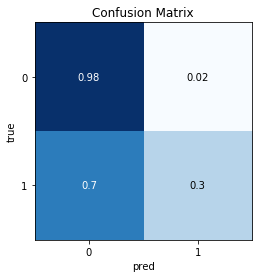

In [122]:
display_results(results)

## Focal Loss

https://arxiv.org/abs/1708.02002

In [37]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes)
        t = torch.Tensor(t[:,:-1].contiguous()).cuda()
        x = pred[:, :-1]
        w = self.get_weight(x, t)
        return F.binary_cross_entropy_with_logits(x, t, w, reduction = "sum")/self.num_classes
    
    def get_weight(self, x, t): return None
    
class FocalLoss(BCE_Loss):
    def __init__(self, num_classes, alpha, gamma):
        super().__init__(num_classes)
        self.alpha = alpha
        self.gamma = gamma
        
    def get_weight(self,x,t):
        p = x.detach().sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = self.alpha*t + (1-self.alpha)*(1-t)
        return w * (1-pt).pow(self.gamma)

In [70]:
loss_f = FocalLoss(2, percent_true / 100, 2)

In [71]:
num_vars = 19
num_back = 40

In [72]:
random_seed(42, True)
train_data = (TimeWindowList(indexes, num_back, data_input)
            .split_by_idx(range(10000))
            .label_from_func(lambda x: x)
            .databunch(bs = 64, num_workers = 0))

In [73]:
learn = Learner(train_data, CNNModel(2, num_vars), loss_func = loss_f, wd = 1e-4)

In [74]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


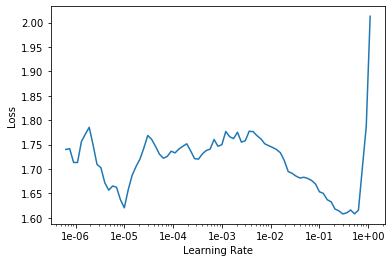

In [75]:
#Helps to choose a learning rate.
#Choose where there is steep decline and then a little back from that.
learn.recorder.plot()

In [76]:
results = do_cross_valid(19, indexes, data_input, num_back, train_metrics,
                         test_metrics, 1e-4, 1e-2, 25, loss_func = loss_f)

epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,1.340416,1.322880,0.795976,0.111736,0.909083,0.031935,00:19
1,1.298101,1.315851,0.724441,0.283728,0.796607,0.074635,00:18
2,1.073248,1.019094,0.668703,0.712997,0.637939,0.256882,00:18
3,1.043057,1.171609,0.851863,0.481412,0.900310,0.422487,00:18
4,1.026867,1.001127,0.799404,0.626153,0.810214,0.387967,00:19
5,1.050712,1.134019,0.382116,0.858764,0.280742,0.093523,00:19
6,1.041432,0.953364,0.738748,0.728059,0.720212,0.338691,00:19
7,0.978092,0.973061,0.653800,0.784111,0.612414,0.259926,00:19
8,0.969260,0.976463,0.801341,0.652824,0.808532,0.400704,00:18
9,0.971960,0.967542,0.763040,0.706613,0.753103,0.365040,00:19


Better model found at epoch 0 with valid_loss value: 1.3228795528411865.
Better model found at epoch 1 with valid_loss value: 1.3158512115478516.
Better model found at epoch 2 with valid_loss value: 1.019093632698059.
Better model found at epoch 4 with valid_loss value: 1.001127004623413.
Better model found at epoch 6 with valid_loss value: 0.9533635377883911.
Epoch 12: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,1.309761,1.259615,0.528018,0.404129,0.530807,0.014674,00:18
1,1.198602,1.057778,0.861252,0.303039,0.935053,0.315550,00:18
2,1.064285,1.012963,0.673025,0.684527,0.646040,0.248586,00:18
3,1.089010,1.175116,0.886885,0.204238,0.977640,0.318864,00:18
4,1.063620,0.969418,0.853204,0.419070,0.905105,0.375124,00:18
5,1.056638,0.981596,0.849627,0.433231,0.892376,0.390442,00:18
6,1.051826,0.937568,0.811922,0.565509,0.826746,0.381537,00:18
7,1.009796,0.931998,0.790164,0.604892,0.793784,0.361732,00:18
8,1.031440,0.924032,0.791207,0.606154,0.794294,0.366403,00:18
9,0.992097,0.901740,0.830104,0.556405,0.850744,0.407117,00:18


Better model found at epoch 0 with valid_loss value: 1.2596145868301392.
Better model found at epoch 1 with valid_loss value: 1.0577784776687622.
Better model found at epoch 2 with valid_loss value: 1.0129631757736206.
Better model found at epoch 4 with valid_loss value: 0.9694177508354187.
Better model found at epoch 6 with valid_loss value: 0.9375683069229126.
Better model found at epoch 7 with valid_loss value: 0.9319984912872314.
Better model found at epoch 8 with valid_loss value: 0.9240316152572632.
Better model found at epoch 9 with valid_loss value: 0.9017403721809387.
Epoch 15: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,1.383105,1.309353,0.857973,0.010174,0.994866,0.007739,00:18
1,1.225428,1.082487,0.756185,0.364475,0.808899,0.185227,00:18
2,1.082381,1.100615,0.881967,0.319385,0.963278,0.406787,00:18
3,1.061043,1.048440,0.706408,0.359446,0.747949,0.127988,00:18
4,1.010292,0.960627,0.781073,0.636037,0.783996,0.364576,00:18
5,1.028700,0.980223,0.714158,0.703099,0.696236,0.295529,00:18
6,1.031996,0.993104,0.824292,0.543254,0.849351,0.403169,00:18
7,0.992381,0.975633,0.833085,0.560829,0.858805,0.424839,00:18
8,0.990148,1.026854,0.859314,0.491019,0.901820,0.452732,00:19
9,1.014129,0.976017,0.662891,0.770654,0.622418,0.265056,00:18


Better model found at epoch 0 with valid_loss value: 1.3093526363372803.
Better model found at epoch 1 with valid_loss value: 1.0824874639511108.
Better model found at epoch 3 with valid_loss value: 1.048439860343933.
Better model found at epoch 4 with valid_loss value: 0.9606269001960754.
Better model found at epoch 10 with valid_loss value: 0.9395654797554016.
Better model found at epoch 12 with valid_loss value: 0.933393120765686.
Epoch 18: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,1.331935,1.310506,0.836960,0.097824,0.952678,0.086002,00:19
1,1.202332,1.099873,0.722355,0.633759,0.716135,0.286294,00:18
2,1.059907,0.957426,0.752161,0.683277,0.738980,0.347351,00:18
3,1.025789,1.021711,0.599702,0.767264,0.548646,0.214318,00:18
4,1.008456,0.924452,0.796274,0.658777,0.796753,0.402795,00:18
5,1.037046,0.982139,0.653353,0.768479,0.611302,0.262480,00:18
6,1.013328,0.969514,0.709091,0.714777,0.684106,0.305173,00:18
7,1.028079,0.916558,0.710730,0.739469,0.682828,0.316658,00:19
8,1.000128,0.956679,0.560060,0.796933,0.496472,0.194168,00:19
9,1.004920,0.929499,0.790313,0.685229,0.785084,0.403427,00:18


Better model found at epoch 0 with valid_loss value: 1.3105061054229736.
Better model found at epoch 1 with valid_loss value: 1.0998731851577759.
Better model found at epoch 2 with valid_loss value: 0.9574263095855713.
Better model found at epoch 4 with valid_loss value: 0.9244519472122192.
Better model found at epoch 7 with valid_loss value: 0.9165583848953247.
Better model found at epoch 10 with valid_loss value: 0.8843110799789429.
Epoch 16: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,1.369309,1.249551,0.125633,0.857625,0.000183,-0.000255,00:18
1,1.263210,1.106997,0.488674,0.755119,0.428330,0.123471,00:19
2,1.100841,0.988544,0.630104,0.720874,0.597133,0.210524,00:19
3,1.043954,0.930033,0.596274,0.779475,0.550550,0.200223,00:18
4,1.066721,1.015446,0.770641,0.621786,0.776065,0.322499,00:18
5,1.016046,1.006092,0.513711,0.809579,0.449993,0.151789,00:18
6,0.997218,0.921204,0.609091,0.788588,0.562931,0.214853,00:18
7,1.027391,0.969135,0.694337,0.721639,0.673012,0.267549,00:19
8,0.994462,0.903889,0.818778,0.577211,0.837321,0.382692,00:18
9,1.020242,0.942269,0.844709,0.490871,0.879825,0.396207,00:19


Better model found at epoch 0 with valid_loss value: 1.2495514154434204.
Better model found at epoch 1 with valid_loss value: 1.1069971323013306.
Better model found at epoch 2 with valid_loss value: 0.9885436296463013.
Better model found at epoch 3 with valid_loss value: 0.9300332069396973.
Better model found at epoch 6 with valid_loss value: 0.9212035536766052.
Better model found at epoch 8 with valid_loss value: 0.9038894176483154.
Better model found at epoch 10 with valid_loss value: 0.9025695323944092.
Better model found at epoch 12 with valid_loss value: 0.8827022314071655.
Better model found at epoch 15 with valid_loss value: 0.8725206851959229.
Better model found at epoch 19 with valid_loss value: 0.8723558783531189.
Better model found at epoch 23 with valid_loss value: 0.869295060634613.


In [77]:
results

array([[array([[4193, 1625],
       [ 148,  690]], dtype=int64), 0.7336238026618958, 0.3101372185940864,
        0.8568685693563962],
       [array([[4893,  816],
       [ 298,  649]], dtype=int64), 0.8326321840286255, 0.44163941551686725,
        0.8570326443195436],
       [array([[4323, 1489],
       [ 152,  692]], dtype=int64), 0.7534555196762085, 0.33613438431904175,
        0.8636453056757875],
       [array([[4040, 1689],
       [ 168,  759]], dtype=int64), 0.7210035920143127, 0.31046523459884434,
        0.8602315327137261],
       [array([[4374, 1361],
       [ 152,  769]], dtype=int64), 0.7726863026618958, 0.3853435999374023,
        0.8745166307423321]], dtype=object)

In [80]:
for result in results:
    print("False Acc: ", result[0][0][0] / sum(result[0][0]))
    print("True Acc: ", result[0][1][1] / sum(result[0][1]))
    print()

False Acc:  0.7206943966998969
True Acc:  0.8233890214797136

False Acc:  0.8570677877036259
True Acc:  0.6853220696937699

False Acc:  0.743805918788713
True Acc:  0.8199052132701422

False Acc:  0.70518415081166
True Acc:  0.8187702265372169

False Acc:  0.7626852659110723
True Acc:  0.8349619978284474



Accuracy: 0.7626802802085877
KappaScore: 0.3567439705932484
AUC_ROC: 0.8624589365615571


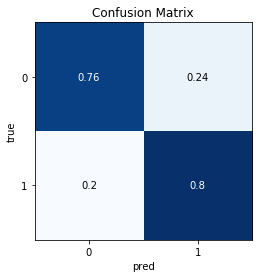

In [78]:
display_results(results)

# Data Manipulation

## Remove Peak Above Input

This section only uses the data where the input does not include a single peak above threshold.

In [32]:
filt = np.array(df.filtLFP)
hilb = np.array(df.hilbLFP)
num_back = 40

In [33]:
def includes_peak_above(lfp, hilb, thresh):
    peaks = s.argrelextrema(lfp, np.greater)[0]
    for peak in peaks:
        if hilb[peak] >= thresh:
            return True
    return False

In [34]:
includes_peak = []
for i in range(len(df)):
    lfp = filt[max(0, i - num_back): i]
    hilbert = hilb[max(0, i - num_back): i]
    includes_peak.append(includes_peak_above(lfp, hilbert, 2))

In [37]:
#Percent of data removed.
len(np.where(np.array(includes_peak) == True)[0]) / len(df) * 100

24.537882589061716

In [42]:
#Percent of inputs labeled true removed.
true_inds = [i for i in range(len(df)) if labels.next_above[i] == 1]
nullified_true_inds = [i for i in range(len(df)) if labels.next_above[i] == 1 and includes_peak[i] == True]
len(nullified_true_inds) / len(true_inds) * 100

46.516228295113194

In [43]:
#Percent of inputs labeled false removed.
false_inds = [i for i in range(len(df)) if labels.next_above[i] != 1]
nullified_false_inds = [i for i in range(len(df)) if labels.next_above[i] != 1 and includes_peak[i] == True]
len(nullified_false_inds) / len(false_inds) * 100

21.049755235404238

In [49]:
#Stores all input except for filtLFP and hilbLFP.
data_input = np.stack([df[columns[i]] for i in range(16)] + [df[columns[i]] for i in range(-3, 0)]  + [labels.next_above], axis = -1)

In [48]:
#Gets the indexes in data_input where it is only 3 or less ms until the next peak 
#and the input does not include a peak above.
#Right now only using df[:-30000] so test set is kept, don't know if necessary.
indexes = np.array([i for i in range(100, len(df) - 30000) 
                    if labels.time_until_peak[i] <= 3 and labels.time_until_peak[i] >= 1 and includes_peak[i] == False])

In [50]:
num_true = len(np.where(np.array(labels.next_above[indexes]) == 1)[0])
num_true

2311

In [51]:
#Percent of input that is labeled as above threshold.
percent_true = (num_true / len(indexes)) * 100

In [54]:
#Was about 13.4% before removals.
percent_true

8.925881580471978

In [55]:
len(indexes)

25891

In [70]:
#Shows that the highest peak being used in all the data now, should be bellow 2
mx = 0
for i in indexes:
    peaks = s.argrelextrema(filt[i - num_back : i], np.greater)[0]
    hilbert = hilb[i - num_back : i]
    for peak in peaks:
        if hilbert[peak] >= mx:
            mx = hilbert[peak]
mx

1.9998

In [71]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes)
        t = torch.Tensor(t[:,:-1].contiguous()).cuda()
        x = pred[:, :-1]
        w = self.get_weight(x, t)
        return F.binary_cross_entropy_with_logits(x, t, w, reduction = "sum")/self.num_classes
    
    def get_weight(self, x, t): return None
    
class FocalLoss(BCE_Loss):
    def __init__(self, num_classes, alpha, gamma):
        super().__init__(num_classes)
        self.alpha = alpha
        self.gamma = gamma
        
    def get_weight(self,x,t):
        p = x.detach().sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = self.alpha*t + (1-self.alpha)*(1-t)
        return w * (1-pt).pow(self.gamma)

In [72]:
loss_f = FocalLoss(2, percent_true / 100, 2)

In [74]:
num_vars = 19

In [82]:
random_seed(43, True)
train_data = (TimeWindowList(indexes, num_back, data_input)
            .split_by_idx(range(10000))
            .label_from_func(lambda x: x)
            .databunch(bs = 64, num_workers = 0))

In [83]:
learn = Learner(train_data, CNNModel(2, num_vars), loss_func = loss_f, wd = 1e-4)

In [84]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


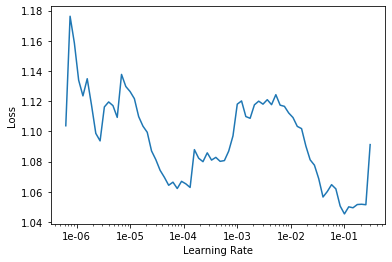

In [85]:
#Helps to choose a learning rate.
#Choose where there is steep decline and then a little back from that.
learn.recorder.plot(skip_end = 10)

In [90]:
results = do_cross_valid(19, indexes, data_input, num_back, train_metrics,
                         test_metrics, 1e-4, 1e-2, 25, loss_func = loss_f)

epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.946183,0.915306,0.486868,0.508005,0.478935,0.013819,00:14
1,0.906633,0.917485,0.412708,0.500609,0.393819,-0.001904,00:14
2,0.859299,0.788085,0.285825,0.571649,0.246376,-0.017387,00:14
3,0.810050,0.870193,0.241792,0.335946,0.224996,-0.086944,00:14
4,0.828383,0.776780,0.455002,0.200369,0.473792,-0.087256,00:14
5,0.790197,0.874843,0.358633,0.803389,0.302077,0.054284,00:14
6,0.781046,0.749967,0.512939,0.627220,0.490152,0.068720,00:14
7,0.782758,0.762848,0.681730,0.594162,0.680229,0.163037,00:14
8,0.743061,0.745009,0.658555,0.679672,0.645761,0.172067,00:14
9,0.768025,0.748937,0.509270,0.792206,0.469597,0.111740,00:14


Better model found at epoch 0 with valid_loss value: 0.9153055548667908.
Better model found at epoch 2 with valid_loss value: 0.788085401058197.
Better model found at epoch 4 with valid_loss value: 0.776780366897583.
Better model found at epoch 6 with valid_loss value: 0.7499667406082153.
Better model found at epoch 8 with valid_loss value: 0.7450085282325745.
Better model found at epoch 10 with valid_loss value: 0.7029502391815186.
Epoch 16: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.950748,0.883458,0.190035,0.733422,0.124500,0.002678,00:14
1,0.897301,0.877867,0.368289,0.425387,0.351420,-0.026653,00:14
2,0.867483,0.770538,0.591155,0.085786,0.636593,-0.111860,00:14
3,0.789374,0.743536,0.609502,0.472234,0.613319,0.067582,00:14
4,0.779762,0.693964,0.384318,0.713120,0.341049,0.048201,00:14
5,0.784848,0.751962,0.682889,0.578697,0.679089,0.165596,00:14
6,0.765826,0.686679,0.748938,0.634028,0.745622,0.247415,00:14
7,0.743466,0.719626,0.683082,0.659452,0.671324,0.192312,00:14
8,0.789446,0.719529,0.281769,0.725152,0.225667,0.022956,00:14
9,0.710458,0.696458,0.871958,0.395416,0.909462,0.314327,00:14


Better model found at epoch 0 with valid_loss value: 0.8834583759307861.
Better model found at epoch 1 with valid_loss value: 0.8778674602508545.
Better model found at epoch 2 with valid_loss value: 0.7705382704734802.
Better model found at epoch 3 with valid_loss value: 0.7435360550880432.
Better model found at epoch 4 with valid_loss value: 0.6939640641212463.
Better model found at epoch 6 with valid_loss value: 0.6866791248321533.
Better model found at epoch 10 with valid_loss value: 0.6744602918624878.
Better model found at epoch 12 with valid_loss value: 0.6725135445594788.
Better model found at epoch 13 with valid_loss value: 0.6640081405639648.
Better model found at epoch 14 with valid_loss value: 0.6632679104804993.
Better model found at epoch 16 with valid_loss value: 0.6590422987937927.
Better model found at epoch 17 with valid_loss value: 0.6468637585639954.
Better model found at epoch 18 with valid_loss value: 0.6461076140403748.
Epoch 24: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,1.019721,0.903656,0.908073,0.006523,0.996553,0.005437,00:14
1,0.935008,0.902502,0.895713,0.013390,0.982904,-0.013515,00:14
2,0.905118,0.901042,0.786211,0.151150,0.845594,0.017312,00:14
3,0.909921,0.876711,0.454616,0.370028,0.461459,-0.045663,00:14
4,0.804109,0.755350,0.683855,0.555232,0.691709,0.127886,00:14
5,0.779652,0.773138,0.642912,0.692257,0.629981,0.151538,00:14
6,0.791573,0.759724,0.711472,0.666919,0.708633,0.195980,00:14
7,0.768834,0.751452,0.712437,0.670455,0.709894,0.199024,00:14
8,0.724830,0.724724,0.675937,0.685439,0.667929,0.170291,00:14
9,0.759087,0.747110,0.827346,0.505194,0.853850,0.274606,00:14


Better model found at epoch 0 with valid_loss value: 0.9036564230918884.
Better model found at epoch 1 with valid_loss value: 0.9025018811225891.
Better model found at epoch 2 with valid_loss value: 0.9010424017906189.
Better model found at epoch 3 with valid_loss value: 0.8767107725143433.
Better model found at epoch 4 with valid_loss value: 0.7553502321243286.
Better model found at epoch 7 with valid_loss value: 0.7514517903327942.
Better model found at epoch 8 with valid_loss value: 0.7247236371040344.
Better model found at epoch 12 with valid_loss value: 0.7221754789352417.
Better model found at epoch 14 with valid_loss value: 0.7106549143791199.
Better model found at epoch 18 with valid_loss value: 0.7093935012817383.
Epoch 24: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.928901,0.919628,0.863075,0.073692,0.943167,0.037723,00:14
1,0.905926,0.914212,0.148320,0.768871,0.069671,-0.004565,00:14
2,0.896393,0.866229,0.198146,0.747059,0.126499,0.005559,00:14
3,0.819629,0.804406,0.550019,0.701686,0.522616,0.113410,00:14
4,0.811850,0.787026,0.346659,0.830464,0.282595,0.061154,00:14
5,0.804112,0.728852,0.482812,0.809415,0.437279,0.107996,00:14
6,0.763146,0.730235,0.651024,0.742029,0.629624,0.192142,00:14
7,0.751496,0.779394,0.469679,0.804462,0.422090,0.102848,00:14
8,0.759581,0.785815,0.764774,0.642024,0.765661,0.272702,00:14
9,0.733276,0.698859,0.599652,0.762981,0.569854,0.162189,00:14


Better model found at epoch 0 with valid_loss value: 0.9196281433105469.
Better model found at epoch 1 with valid_loss value: 0.9142117500305176.
Better model found at epoch 2 with valid_loss value: 0.8662294149398804.
Better model found at epoch 3 with valid_loss value: 0.8044064044952393.
Better model found at epoch 4 with valid_loss value: 0.7870262861251831.
Better model found at epoch 5 with valid_loss value: 0.7288516163825989.
Better model found at epoch 9 with valid_loss value: 0.6988593935966492.
Better model found at epoch 11 with valid_loss value: 0.6743885278701782.
Epoch 17: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.941867,0.883276,0.089996,0.859920,0.004660,0.000414,00:14
1,0.932119,0.884383,0.101390,0.855579,0.017575,0.001529,00:14
2,0.912479,0.885163,0.121282,0.830779,0.041784,0.000724,00:14
3,0.823068,0.788109,0.446504,0.732359,0.407581,0.069753,00:14
4,0.800247,0.856801,0.229432,0.839280,0.159436,0.026315,00:14
5,0.805571,0.754924,0.564117,0.718199,0.538330,0.119504,00:14
6,0.813101,0.828922,0.882001,0.292859,0.932751,0.266119,00:14
7,0.763570,0.722763,0.706257,0.643428,0.701927,0.193500,00:14
8,0.782452,0.738563,0.627462,0.713303,0.609608,0.152141,00:14
9,0.772502,0.729585,0.535535,0.744725,0.504256,0.112244,00:14


Better model found at epoch 0 with valid_loss value: 0.8832760453224182.
Better model found at epoch 3 with valid_loss value: 0.7881088256835938.
Better model found at epoch 5 with valid_loss value: 0.7549241185188293.
Better model found at epoch 7 with valid_loss value: 0.722763180732727.
Better model found at epoch 11 with valid_loss value: 0.6937925815582275.
Better model found at epoch 14 with valid_loss value: 0.6783206462860107.
Better model found at epoch 15 with valid_loss value: 0.6685185432434082.
Better model found at epoch 18 with valid_loss value: 0.6670432686805725.
Better model found at epoch 20 with valid_loss value: 0.662739098072052.


In [91]:
results

array([[array([[3258, 1423],
       [  98,  341]], dtype=int64), 0.702929675579071, 0.19968495158761546,
        0.8169596084398764],
       [array([[3289, 1360],
       [ 107,  364]], dtype=int64), 0.7134765386581421, 0.2187711921877119,
        0.825403175533948],
       [array([[3348, 1333],
       [  81,  358]], dtype=int64), 0.723828136920929, 0.2315300594359223,
        0.8357675262620812],
       [array([[3098, 1562],
       [ 108,  352]], dtype=int64), 0.673828125, 0.17737156051568215, 0.7939900167941781],
       [array([[3335, 1307],
       [  83,  395]], dtype=int64), 0.728515625, 0.25357292389481223, 0.8548346099556712]], dtype=object)

In [92]:
for result in results:
    print("False Acc: ", result[0][0][0] / sum(result[0][0]))
    print("True Acc: ", result[0][1][1] / sum(result[0][1]))
    print()

False Acc:  0.696005127109592
True Acc:  0.7767653758542141

False Acc:  0.7074639707463971
True Acc:  0.772823779193206

False Acc:  0.7152317880794702
True Acc:  0.8154897494305239

False Acc:  0.6648068669527897
True Acc:  0.7652173913043478

False Acc:  0.7184403274450668
True Acc:  0.8263598326359832



Accuracy: 0.7085156202316284
KappaScore: 0.2161861375243488
AUC_ROC: 0.8253909873971509


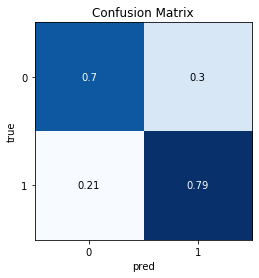

In [93]:
display_results(results)